In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

# parallelisation functionality
from multiprocess import Pool
import psutil
from tqdm import tqdm

# Analysis of the effect of being an incumbent

In [2]:
src = "../data/processed"
dst = "../results"
plt_dst = "../plots"

## Create candidate information table

In [3]:
fname = "study_data.csv.gzip"
tweets = pd.read_csv(
    Path(src, fname),
    dtype={"id":str, "author_id":str},
    parse_dates=["created_at", "ELECTIONDATE"],
    compression="gzip"
)

In [4]:
candidates = tweets[["handle", "PARTY", "ELECTIONDATE", "INCUMBENT", "id"]]\
    .groupby(["handle", "PARTY", "ELECTIONDATE", "INCUMBENT"])\
    .count()\
    .rename(columns={"id":"N_tweets"})\
    .reset_index()
candidates = candidates.set_index(["handle", "ELECTIONDATE"])
candidates.head(3)

,,PARTY,INCUMBENT,N_tweets
handle,ELECTIONDATE,,,
1haywood,2022-05-17,R,0.0,3
aarikarhodes,2022-06-07,D,0.0,95
aazamishervin,2022-06-07,D,0.0,154


In [5]:
# calculate the number of tweets before the election
candidates["N_tweets_before"] = 0
# note: it is necessary to have a double-index, since there is one candidate
# (farrforus) who ran in two elections
i = 0
for handle, electiondate in candidates.index:
    if i%100 == 0:
        print(f"{i}/{len(candidates)}")
    # select only tweets of the candidate from the four weeks leading up to the 
    # election date
    candidate_tweets = tweets[tweets["handle"] == handle]
    candidate_tweets = candidate_tweets[
        (candidate_tweets["created_at"].dt.date <= electiondate.date()) & \
        (candidate_tweets["created_at"].dt.date >= electiondate.date() - pd.Timedelta(days=28))
    ]
    candidates.loc[(handle, electiondate), "N_tweets_before"] = len(candidate_tweets)
    i += 1

0/984
100/984
200/984
300/984
400/984
500/984
600/984
700/984
800/984
900/984


In [6]:
len(candidates[candidates["N_tweets_before"] > 0])

945

In [7]:
candidates[candidates["N_tweets_before"] > 0]["INCUMBENT"].value_counts()

INCUMBENT
0.0    645
1.0    300
Name: count, dtype: int64

In [8]:
candidates[candidates["N_tweets_before"] > 0]["PARTY"].value_counts()

PARTY
R    493
D    452
Name: count, dtype: int64

## Power analysis

### Linear mixed-effects model simulations

In [9]:
# define simulation parameters
n_sim = 100  # Number of simulations
alpha = 0.05  # Significance level

# sample sizes
subset = candidates[candidates["N_tweets_before"] > 0]
n_groups = len(subset)
n_incumbents = len(subset[subset["INCUMBENT"] == 1])
n_democrats = len(subset[subset["PARTY"] == "D"])

# variance components - from script estimate_variance_factors_pilot_data.ipynb
variance_components = {}
fname = "variance_components_incumbent_analysis_belief_speaking.txt"
with open(Path(dst, "variance_components", fname), "r") as infile:
    for line in infile:
        key, val = line.rstrip().split("=")
        variance_components[key] = float(val)
    
var_intercept = variance_components["var_intercept"]
var_residual = variance_components["var_residual"]

In [10]:
from numpy.linalg import LinAlgError

def simulate_lme(params):
    random_state, beta_T, beta_P, beta_TP = params
    
    n_obs_per_group = subset["N_tweets_before"]\
        .sample(n_groups, random_state=random_state)\
        .values.astype(int)
    total_n = n_obs_per_group.sum()

    # generate simulated data
    group = np.repeat(np.arange(n_groups), n_obs_per_group)

    # binary predictor of the candidate type
    T_group = np.random.binomial(1, n_incumbents / n_groups, n_groups)
    T_observations = np.repeat(T_group, n_obs_per_group)
    
    # binary predictor of the party
    P_group = np.random.binomial(1, n_democrats/ n_groups, n_groups)  
    P_observations = np.repeat(P_group, n_obs_per_group)

    random_intercepts = np.random.normal(0, np.sqrt(var_intercept), n_groups)
    random_effects = random_intercepts[group]
    errors = np.random.normal(0, np.sqrt(var_residual), total_n)

    # calculate dependent variable
    D = (0 + beta_T * T_observations + beta_P * P_observations + \
         beta_TP * T_observations * P_observations + random_effects + errors)
    data = pd.DataFrame({'D': D, 'C': group, 'T': T_observations, 'P': P_observations})

    # fit the linear mixed effects model
    model = smf.mixedlm("D ~ T * P", data, groups=data["C"])

    try:
        result = model.fit()
    except LinAlgError:
        print("LinAlgError")

    # assess significance of the effects, handle cases where the term is not estimable
    try:
        p_value_interaction = result.pvalues['T:P']
    except KeyError:
        p_value_interaction = np.nan
    try:
        p_value_P = result.pvalues['P']
    except KeyError:
        p_value_P = np.nan
    try:
        p_value_T = result.pvalues['T']
    except KeyError:
        p_value_T = np.nan

    return (random_state, beta_T, beta_P, beta_TP, p_value_T, p_value_P, p_value_interaction)

In [11]:
beta_Ts = [0.005, 0.01, 0.015, 0.02, 0.025, 0.03]
beta_Ps = [0.005, 0.01, 0.015, 0.02, 0.025, 0.03]
beta_TPs = [0.005, 0.01, 0.015, 0.02, 0.025, 0.03]
random_states = range(n_sim)

params = [(i, beta_Ts[j], beta_Ps[j], beta_TPs[j])\
              for j in range(len(beta_Ts))\
              for i in random_states] 
N_configs = len(params)

In [ ]:
results = pd.DataFrame()
pool = Pool(10)

for tmp1, tmp2, tmp3, tmp4, tmp5, tmp6, tmp7 in tqdm(pool.imap_unordered(
    func=simulate_lme, 
    iterable=params), 
    total=N_configs):

    results = pd.concat([results, pd.DataFrame({
        "random_state":[tmp1],
        "beta_T":[tmp2],
        "beta_P":[tmp3],
        "beta_TP":[tmp4],
        "p_value_T":[tmp5],
        "p_value_P":[tmp6],
        "p_value_TP":[tmp7]
    })])

pool.close()

results["alpha"] = alpha
results["var_intercept"] = var_intercept
results["var_residual"] = var_residual
fname = "incumbent_power_analysis.csv"
results.to_csv(Path(dst, fname), index=False)

### Calculate power

In [13]:
# calculate power bootstrapped
fname = "incumbent_power_analysis.csv"
results = pd.read_csv(Path(dst, fname))
power_bootstrap = pd.DataFrame()

n_bootstrap = 100
for beta_T, beta_P, beta_TP in zip(beta_Ts, beta_Ps, beta_TPs):
    for n in range(n_bootstrap):
        res = results[
            (results["beta_T"] == beta_T) & \
            (results["beta_P"] == beta_P) & \
            (results["beta_TP"] == beta_TP)
        ].sample(frac=1, replace=True)
    
        power_T = np.nanmean(res["p_value_T"].values < alpha)
        power_P = np.nanmean(res["p_value_P"].values < alpha)
        power_TP = np.nanmean(res["p_value_TP"].values < alpha)
        
        power_bootstrap = pd.concat([power_bootstrap, pd.DataFrame({
            "variable":["$T$"],
            "effect":[beta_T],
            "power":[power_T],
        })])
        power_bootstrap = pd.concat([power_bootstrap, pd.DataFrame({
            "variable":["$P$"],
            "effect":[beta_P],
            "power":[power_P],
        })])
        power_bootstrap = pd.concat([power_bootstrap, pd.DataFrame({
            "variable":["$T \\times P$"],
            "effect":[beta_TP],
            "power":[power_TP]
        })])

In [14]:
power_bootstrap.head(3)

,variable,effect,power
0,$T$,0.005,0.39
0,$P$,0.005,0.32
0,$T \times P$,0.005,0.02


### Visualisation of power analysis

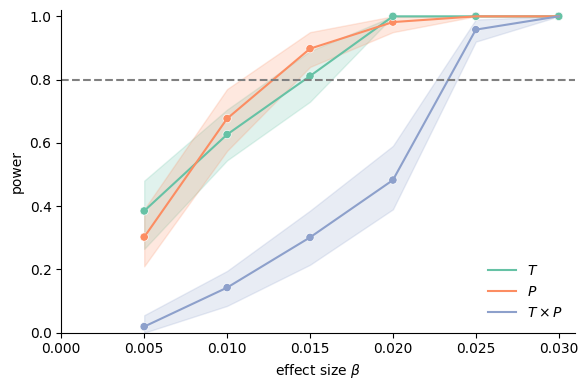

In [15]:
fig, ax = plt.subplots(figsize=(6, 4))

sns.lineplot(
    data=power_bootstrap,
    ax=ax,
    x="effect", 
    y="power",
    hue="variable",
    errorbar="pi",
    palette="Set2",
)

sns.scatterplot(
    data=power_bootstrap.groupby(["variable", "effect"]).mean().reset_index(),
    ax=ax,
    x="effect",
    y="power",
    hue="variable",
    hue_order=["$T$", "$P$", "$T \\times P$"],
    sizes=[50, 50, 50],
    palette="Set2",
    legend=False
)

ax.set_xlabel("effect size $\\beta$")
ax.spines[['right', 'top']].set_visible(False)
ax.legend(frameon=False)
ax.plot([0, 0.031], [0.8, 0.8], '--', color="grey")
ax.set_xlim(0, 0.031)
ax.set_ylim(0, 1.02)
plt.tight_layout()

fname = "power_analysis_incumbent"
plt.savefig(Path(plt_dst, fname + ".pdf"))
plt.savefig(Path(plt_dst, fname + ".svg"))

## Main analysis

TODO